# Batch UCB
- use your favorite kernel to generate distance matrix
- clustering (k-metriod)
- large clustering numbers: reject clustering for which the max UCB is smaller other clustering's LCB; then choose sequences in the remaining clusterings by UCB.
- small clustering numbers, e.g. 90, choose one sequence from each clustering by UCB.

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import Spectrum_Kernel, Sum_Spectrum_Kernel, WeightedDegree_Kernel

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

In [2]:
Path = '../../data/firstRound_4h_normTrue_formatSeq_logTrue.csv'

df_frr = pd.read_csv(Path)
df_frr.head()

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,1.866788,0.255154
1,1,RBS_1by1_1,bps_noncore,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.181122,NaN,1.309597,1.693182,1.394633,0.266411
2,2,RBS_1by1_2,bps_noncore,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.700778,NaN,0.331062,0.493596,0.508479,0.185307
3,3,RBS_1by1_3,bps_noncore,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.287142,NaN,1.156889,1.356925,1.266986,0.101530
4,4,RBS_1by1_4,bps_noncore,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,1.379619,NaN,1.406433,1.374056,1.386702,0.017312


In [3]:
df_frr.sort_values('AVERAGE', ascending=False)

,Unnamed: 0,Name,Group,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,AVERAGE,STD
115,138,RBS_BA_48,bandit,TTTAAGACTTTTTTATACAT,CTTTTT,2.251241,1.459262,2.314395,NaN,NaN,2.008299,0.476528
0,0,RBS_1by1_0,reference,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,1.866788,0.255154
145,173,RBS_RP_54,prob random,TTTAAGATAGTCTTATACAT,TAGTCT,1.927534,1.295124,1.925422,NaN,NaN,1.716027,0.364514
114,137,RBS_BA_47,bandit,TTTAAGAGTTTTTTATACAT,GTTTTT,1.776032,1.242683,1.700069,NaN,NaN,1.572928,0.288512
59,60,RBS_1by1_60,bps_noncore,TTTAAGAAGGAGATATACAA,AGGAGA,NaN,1.290180,NaN,1.528015,1.799340,1.539178,0.254764
...,...,...,...,...,...,...,...,...,...,...,...,...
42,43,RBS_1by1_43,bps_noncore,TTTAAGAAGGAGATCTACAT,AGGAGA,NaN,-1.738476,NaN,-2.236443,-2.050203,-2.008374,0.251605
121,145,RBS_BA_55,bandit,TTTAAGAACCCCCTATACAT,ACCCCC,-1.295039,-3.277385,-1.510607,NaN,NaN,-2.027677,1.087633
29,30,RBS_1by1_30,bps_core,TTTAAGAAGTAGATATACAT,AGTAGA,NaN,-3.048645,NaN,-1.142859,-1.896742,-2.029416,0.959795
113,136,RBS_BA_46,bandit,TTTAAGATTTTTATATACAT,TTTTTA,-1.060786,-3.230272,-1.997558,NaN,NaN,-2.096205,1.088102


(array([ 8.,  4., 16., 17., 14., 28., 28., 21., 11.,  3.]),
 array([-2.22735111, -1.80378607, -1.38022104, -0.956656  , -0.53309097,
        -0.10952594,  0.3140391 ,  0.73760413,  1.16116916,  1.5847342 ,
         2.00829923]),
 <a list of 10 Patch objects>)

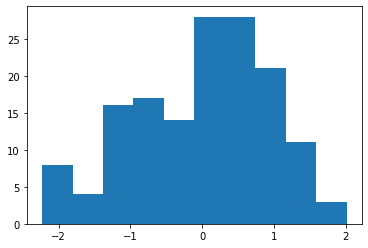

In [4]:
plt.hist(df_frr['AVERAGE'])

In [5]:
frr_rbs_set = set(df_frr['RBS'])

## Create test dataset

In [6]:
# create all combos

combos = [] # 20-base
combos_6 = [] # 6-base
labels = []
char_sets = ['A', 'G', 'C', 'T']
design_len = 6

# to be changed
pre_design = 'TTTAAGA'
pos_design = 'TATACAT'

for combo in itertools.product(char_sets, repeat= design_len):
    
    combo = pre_design + ''.join(combo) + pos_design
    combos_6.append(''.join(combo))
    combos.append(combo)
    labels.append(math.inf)
    
assert len(combos) == len(char_sets) ** design_len
# len(combos)

In [7]:
df_design = pd.DataFrame()
df_design['RBS'] = list(set(combos) - frr_rbs_set)
#df['AVERAGE'] = NaN

In [8]:
df_design

,RBS
0,TTTAAGAACTCGATATACAT
1,TTTAAGAATATTCTATACAT
2,TTTAAGACAGCCATATACAT
3,TTTAAGATGACGTTATACAT
4,TTTAAGATGTGAGTATACAT
...,...
3982,TTTAAGAATTCCCTATACAT
3983,TTTAAGAAGAATCTATACAT
3984,TTTAAGATGTCGATATACAT
3985,TTTAAGAAGAAGTTATACAT


In [9]:
# put first round result (frr) and design space (design) together
# [:150] frr; [150:] design

df_train_test = pd.concat([df_frr, df_design], sort = True).reset_index()

In [10]:
# confirm test part

df_train_test.loc[range(150,len(df_train_test))]

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0
150,0,NaN,NaN,NaN,TTTAAGAACTCGATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
151,1,NaN,NaN,NaN,TTTAAGAATATTCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
152,2,NaN,NaN,NaN,TTTAAGACAGCCATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
153,3,NaN,NaN,NaN,TTTAAGATGACGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
154,4,NaN,NaN,NaN,TTTAAGATGTGAGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,3982,NaN,NaN,NaN,TTTAAGAATTCCCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4133,3983,NaN,NaN,NaN,TTTAAGAAGAATCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4134,3984,NaN,NaN,NaN,TTTAAGATGTCGATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4135,3985,NaN,NaN,NaN,TTTAAGAAGAAGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## K medoids 

In [11]:
kernel_dict = {
    'Spectrum_Kernel': Spectrum_Kernel,
    'WD_Kernel': WeightedDegree_Kernel,
    'Sum_Spectrum_Kernel': Sum_Spectrum_Kernel,
    'Mixed_Spectrum_Kernel': Mixed_Spectrum_Kernel,
    'WD_Kernel_Shift': WD_Shift_Kernel
    
}

log_flag = True

In [12]:
# setting

embedding = 'label'
eva_on_ave_flag = True # true label is the sample mean instead of individual samples, since the prediction is the posterior mean
eva_metric = mean_squared_error # mean square error returns a more stable optimal hyparameter choice than r2 score

kernel = 'WD_Kernel_Shift'
alpha = 0.5
l = [6]

weight_flag = False
padding_flag = False
gap_flag = False
plot_format = 'plt'

In [13]:
distance = kernel_dict[kernel](l_list=l).distance(np.asarray(df_train_test['RBS']))

In [14]:
distance.shape

(4137, 4137)

In [15]:
from sklearn_extra.cluster import KMedoids
kmedoids = KMedoids(n_clusters=90, metric = 'precomputed', init='k-medoids++').fit(distance)
y_km_spec = kmedoids.labels_

In [16]:
df_train_test['cluster'] = y_km_spec

In [17]:
df_train_test

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster
0,0,1.866788,reference,RBS_1by1_0,TTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.572497,NaN,2.001765,2.026102,0.255154,0.0,75
1,1,1.394633,bps_noncore,RBS_1by1_1,CTTAAGAAGGAGATATACAT,AGGAGA,NaN,1.181122,NaN,1.309597,1.693182,0.266411,1.0,75
2,2,0.508479,bps_noncore,RBS_1by1_2,GTTAAGAAGGAGATATACAT,AGGAGA,NaN,0.700778,NaN,0.331062,0.493596,0.185307,2.0,75
3,3,1.266986,bps_noncore,RBS_1by1_3,ATTAAGAAGGAGATATACAT,AGGAGA,NaN,1.287142,NaN,1.156889,1.356925,0.101530,3.0,75
4,4,1.386702,bps_noncore,RBS_1by1_4,TCTAAGAAGGAGATATACAT,AGGAGA,NaN,1.379619,NaN,1.406433,1.374056,0.017312,4.0,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,3982,NaN,NaN,NaN,TTTAAGAATTCCCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57
4133,3983,NaN,NaN,NaN,TTTAAGAAGAATCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55
4134,3984,NaN,NaN,NaN,TTTAAGATGTCGATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69
4135,3985,NaN,NaN,NaN,TTTAAGAAGAAGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55


## Prediction

In [18]:
gpr = GPR_Predictor(df_train_test, train_idx = range(0,150), test_idx = range(150,len(df_train_test)), kernel_name=kernel, normalise_kernel = False, alpha=alpha, embedding='label',
                   eva_metric=eva_metric, l_list=l, s = 0)

In [19]:
gpr.regression()

In [20]:
gpr.train_df

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
89,TTTAAGACGGATTTATACAT,CGGATT,1.010717,0.200051,bandit,Rep1,1.137678,0.995127,0.394297
90,TTTAAGACTCGGATATACAT,CTCGGA,0.438705,0.268057,bandit,Rep1,0.645691,0.473706,0.386677
91,TTTAAGAACCGGATATACAT,ACCGGA,0.323097,0.132360,bandit,Rep1,0.414381,0.226966,0.386623
92,TTTAAGAATCGGATATACAT,ATCGGA,0.240948,0.068313,bandit,Rep1,0.319189,0.250352,0.386894
93,TTTAAGACCGGATTATACAT,CCGGAT,0.060008,0.126417,bandit,Rep1,0.161740,0.050499,0.398151
...,...,...,...,...,...,...,...,...,...
684,TTTAAGAGCTACATATACAT,GCTACA,0.515899,0.229860,uni random,Rep5,0.726697,0.395371,0.397757
685,TTTAAGAGAAGACTATACAT,GAAGAC,-0.197847,0.219579,uni random,Rep5,-0.086876,-0.309530,0.385429
686,TTTAAGACTCCGTTATACAT,CTCCGT,-0.036563,0.101944,uni random,Rep5,-0.016366,-0.067617,0.396947
687,TTTAAGATTACTATATACAT,TTACTA,-0.226934,0.233238,uni random,Rep5,-0.124879,-0.307745,0.397407


In [21]:
gpr.test_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std
150,0,NaN,NaN,NaN,TTTAAGAACTCGATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,-0.332724,1.782790
151,1,NaN,NaN,NaN,TTTAAGAATATTCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79,0.117352,1.492122
152,2,NaN,NaN,NaN,TTTAAGACAGCCATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,-0.250265,1.856211
153,3,NaN,NaN,NaN,TTTAAGATGACGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0.008783,1.750578
154,4,NaN,NaN,NaN,TTTAAGATGTGAGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0.606398,1.502553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,3982,NaN,NaN,NaN,TTTAAGAATTCCCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,-0.936584,1.719392
4133,3983,NaN,NaN,NaN,TTTAAGAAGAATCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,-0.677929,1.637634
4134,3984,NaN,NaN,NaN,TTTAAGATGTCGATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,-0.666874,1.674433
4135,3985,NaN,NaN,NaN,TTTAAGAAGAAGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,-1.129597,1.242517


(array([   6.,    5.,   65.,  299.,  842., 1140.,  931.,  470.,  189.,
          40.]),
 array([-3.01108207, -2.48544148, -1.95980089, -1.43416031, -0.90851972,
        -0.38287913,  0.14276145,  0.66840204,  1.19404263,  1.71968321,
         2.2453238 ]),
 <a list of 10 Patch objects>)

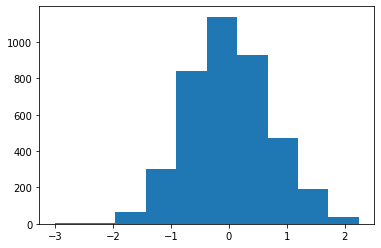

In [22]:
plt.hist(gpr.test_df['pred mean'])

In [23]:
sorted_mean_test_df = gpr.test_df.sort_values(['pred mean'], ascending=False)
sorted_mean_test_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std
1303,1153,NaN,NaN,NaN,TTTAAGACCTTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,2.245324,1.668591
4136,3986,NaN,NaN,NaN,TTTAAGACCGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,2.242120,1.790419
3600,3450,NaN,NaN,NaN,TTTAAGACCGTCTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,2.196808,1.674354
3560,3410,NaN,NaN,NaN,TTTAAGACCGATTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,2.137446,1.563422
166,16,NaN,NaN,NaN,TTTAAGACCCGGCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70,2.101683,1.184091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,101,NaN,NaN,NaN,TTTAAGAACCCCATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,-2.659750,0.773204
3128,2978,NaN,NaN,NaN,TTTAAGAATTTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79,-2.662505,0.808115
2831,2681,NaN,NaN,NaN,TTTAAGAGCCCCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,-2.694607,0.810892
401,251,NaN,NaN,NaN,TTTAAGATCCCCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,-2.826218,0.809328


Text(0.5, 1.0, 'Prediction, sorted by pred mean')

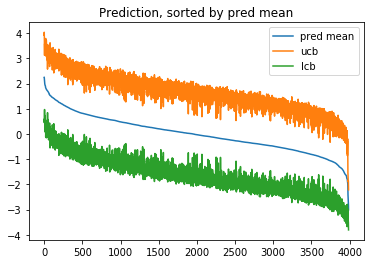

In [24]:
plt.plot(range(len(sorted_mean_test_df)), sorted_mean_test_df['pred mean'], label = 'pred mean')
plt.plot(range(len(sorted_mean_test_df)), sorted_mean_test_df['pred mean'] + sorted_mean_test_df['pred std'], label ='ucb')
plt.plot(range(len(sorted_mean_test_df)), sorted_mean_test_df['pred mean'] - sorted_mean_test_df['pred std'], label ='lcb')
plt.legend()
plt.title('Prediction, sorted by pred mean')

Text(0.5, 1.0, 'Top sequences kernel matrix, sorted by pred mean')

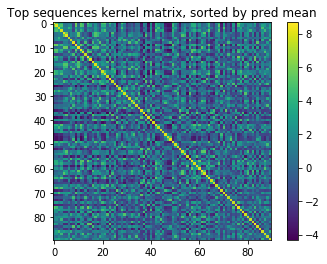

In [25]:
kernel_matrix = kernel_dict[kernel](l_list = l).__call__(np.asarray(sorted_mean_test_df['RBS'])[:90], np.asarray(sorted_mean_test_df['RBS'])[:90])
plt.imshow(kernel_matrix)
plt.colorbar()
plt.title('Top sequences kernel matrix, sorted by pred mean')

## UCB & LCB

In [26]:
test_df = gpr.test_df
test_df['ucb'] = test_df['pred mean'] + test_df['pred std']
test_df['lcb'] = test_df['pred mean'] - test_df['pred std']
test_df

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std,ucb,lcb
150,0,NaN,NaN,NaN,TTTAAGAACTCGATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,-0.332724,1.782790,1.450065,-2.115514
151,1,NaN,NaN,NaN,TTTAAGAATATTCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79,0.117352,1.492122,1.609474,-1.374770
152,2,NaN,NaN,NaN,TTTAAGACAGCCATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,-0.250265,1.856211,1.605947,-2.106476
153,3,NaN,NaN,NaN,TTTAAGATGACGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53,0.008783,1.750578,1.759361,-1.741794
154,4,NaN,NaN,NaN,TTTAAGATGTGAGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,0.606398,1.502553,2.108952,-0.896155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4132,3982,NaN,NaN,NaN,TTTAAGAATTCCCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57,-0.936584,1.719392,0.782807,-2.655976
4133,3983,NaN,NaN,NaN,TTTAAGAAGAATCTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,-0.677929,1.637634,0.959705,-2.315563
4134,3984,NaN,NaN,NaN,TTTAAGATGTCGATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69,-0.666874,1.674433,1.007559,-2.341307
4135,3985,NaN,NaN,NaN,TTTAAGAAGAAGTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,-1.129597,1.242517,0.112919,-2.372114


In [27]:
sorted_ucb = test_df.sort_values(['ucb'], ascending=False)
sorted_ucb

,index,AVERAGE,Group,Name,RBS,RBS6,Rep1,Rep2,Rep3,Rep4,Rep5,STD,Unnamed: 0,cluster,pred mean,pred std,ucb,lcb
4136,3986,NaN,NaN,NaN,TTTAAGACCGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,2.242120,1.790419,4.032539,0.451701
1303,1153,NaN,NaN,NaN,TTTAAGACCTTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,71,2.245324,1.668591,3.913915,0.576732
3600,3450,NaN,NaN,NaN,TTTAAGACCGTCTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,21,2.196808,1.674354,3.871163,0.522454
3863,3713,NaN,NaN,NaN,TTTAAGACCTGTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42,1.831006,1.954273,3.785279,-0.123267
3369,3219,NaN,NaN,NaN,TTTAAGACAGTTTTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,1.923864,1.845378,3.769242,0.078486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3128,2978,NaN,NaN,NaN,TTTAAGAATTTTGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,79,-2.662505,0.808115,-1.854390,-3.470621
2831,2681,NaN,NaN,NaN,TTTAAGAGCCCCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,81,-2.694607,0.810892,-1.883715,-3.505499
251,101,NaN,NaN,NaN,TTTAAGAACCCCATATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33,-2.659750,0.773204,-1.886546,-3.432954
401,251,NaN,NaN,NaN,TTTAAGATCCCCGTATACAT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,-2.826218,0.809328,-2.016889,-3.635546


Text(0.5, 1.0, 'Prediction, sorted by ucb')

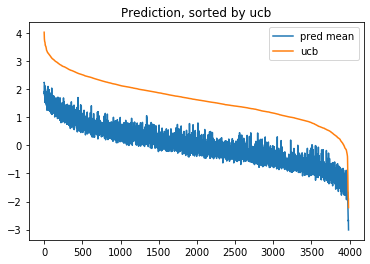

In [28]:

plt.plot(range(len(sorted_ucb)), sorted_ucb['pred mean'], label = 'pred mean')
plt.plot(range(len(sorted_ucb)), sorted_ucb['ucb'], label = 'ucb')
plt.legend()
plt.title('Prediction, sorted by ucb')

(array([26., 23., 11.,  5., 12.,  4.,  4.,  2.,  2.,  1.]),
 array([3.15079113, 3.2389659 , 3.32714068, 3.41531546, 3.50349023,
        3.59166501, 3.67983978, 3.76801456, 3.85618934, 3.94436411,
        4.03253889]),
 <a list of 10 Patch objects>)

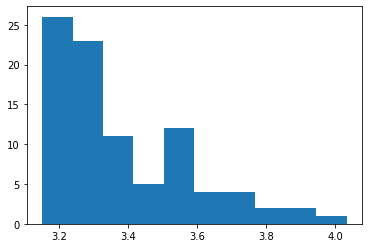

In [29]:
plt.hist(sorted_ucb[:90]['ucb'])

Text(0.5, 1.0, 'Top sequences kernel matrix, sorted by ucb')

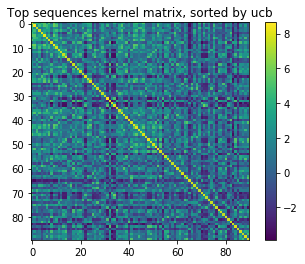

In [30]:
sorted_ucb_kernel_matrix = kernel_dict[kernel](l_list = l).__call__(np.asarray(sorted_ucb['RBS'])[:90], np.asarray(sorted_ucb['RBS'])[:90])
plt.imshow(sorted_ucb_kernel_matrix)
plt.colorbar()
plt.title('Top sequences kernel matrix, sorted by ucb')

In [31]:
sorted_ucb.groupby('cluster').max()['ucb'].min()

1.7103847908424634

In [32]:
sorted_ucb.groupby('cluster').min()['lcb'].max()

-1.8496527854468325

### Discussion: Reject clusters with max ucb smaller min lcb in another cluster?
For 256 clusters, the minimum max ucb among all clusters is 1.35, which is still bigger than maximum min lcb among all clusters (- 1.05)
When we look at single sequences, there are sequence's ucb is smaller than other's lcb.

### Discussion: Select max ucb in each clusters

In [33]:
max_ucb_in_clusters = pd.DataFrame(columns=['RBS', 'ucb', 'pred mean', 'pred std', 'lcb'])

for group, value in sorted_ucb.groupby('cluster'):
    max_ucb_in_clusters.loc[group] = value.sort_values('ucb', ascending = False)[['RBS', 'ucb', 'pred mean', 'pred std', 'lcb']].iloc[0]
    

In [34]:
max_ucb_in_clusters

,RBS,ucb,pred mean,pred std,lcb
0,TTTAAGAGCGTTTTATACAT,3.374224,1.459417,1.914806,-0.455389
1,TTTAAGACCCGGGTATACAT,3.304971,1.946751,1.358220,0.588530
2,TTTAAGAATAGGCTATACAT,2.283669,0.832359,1.451311,-0.618952
3,TTTAAGAGCGATATATACAT,2.298260,0.668790,1.629471,-0.960681
4,TTTAAGACCACTCTATACAT,2.096585,0.444122,1.652463,-1.208341
...,...,...,...,...,...
85,TTTAAGATATGTGTATACAT,2.305796,0.790298,1.515499,-0.725201
86,TTTAAGAGCAGGCTATACAT,2.707669,0.868115,1.839554,-0.971439
87,TTTAAGAAACTAATATACAT,2.038175,0.202747,1.835428,-1.632681
88,TTTAAGACTTTAGTATACAT,3.252442,1.678098,1.574344,0.103753


Text(0.5, 1.0, 'max_ucb_in_clusters')

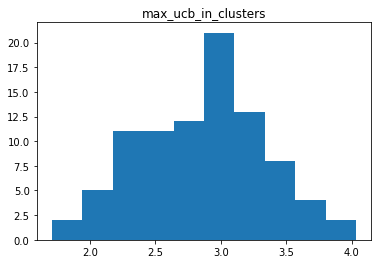

In [35]:
plt.hist(max_ucb_in_clusters['ucb'])
plt.title('max_ucb_in_clusters')

In [36]:
sorted_max_ucb_in_clusters = max_ucb_in_clusters.sort_values('ucb', ascending=False)
sorted_max_ucb_in_clusters

,RBS,ucb,pred mean,pred std,lcb
21,TTTAAGACCGTTTTATACAT,4.032539,2.242120,1.790419,0.451701
71,TTTAAGACCTTTTTATACAT,3.913915,2.245324,1.668591,0.576732
42,TTTAAGACCTGTTTATACAT,3.785279,1.831006,1.954273,-0.123267
13,TTTAAGACAGTTTTATACAT,3.769242,1.923864,1.845378,0.078486
41,TTTAAGACCTTAGTATACAT,3.696634,1.775773,1.920861,-0.145087
...,...,...,...,...,...
81,TTTAAGATCTTAGTATACAT,2.082590,0.303896,1.778694,-1.474799
87,TTTAAGAAACTAATATACAT,2.038175,0.202747,1.835428,-1.632681
57,TTTAAGATAGCCCTATACAT,2.027849,0.248375,1.779474,-1.531098
89,TTTAAGATTTGGATATACAT,1.817483,0.322083,1.495401,-1.173318


Text(0.5, 1.0, 'sorted_max_ucb_clusters_kernel_matrix')

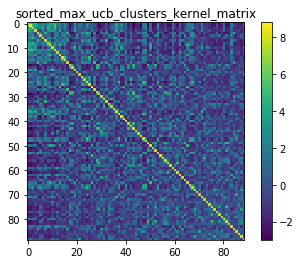

In [37]:
sorted_max_ucb_clusters_kernel_matrix = kernel_dict[kernel](l_list = l).__call__(np.asarray(sorted_max_ucb_in_clusters['RBS']), np.asarray(sorted_max_ucb_in_clusters['RBS']))
plt.imshow(sorted_max_ucb_clusters_kernel_matrix)
plt.colorbar()
plt.title('sorted_max_ucb_clusters_kernel_matrix')

we can see compared with selecting top 100 sequences directly, selecting max ucb in each cluster results in a distrubiton with lower ucbs, but lower similarities as well.

## plot together

Text(0.5, 1.0, 'sorted ucb')

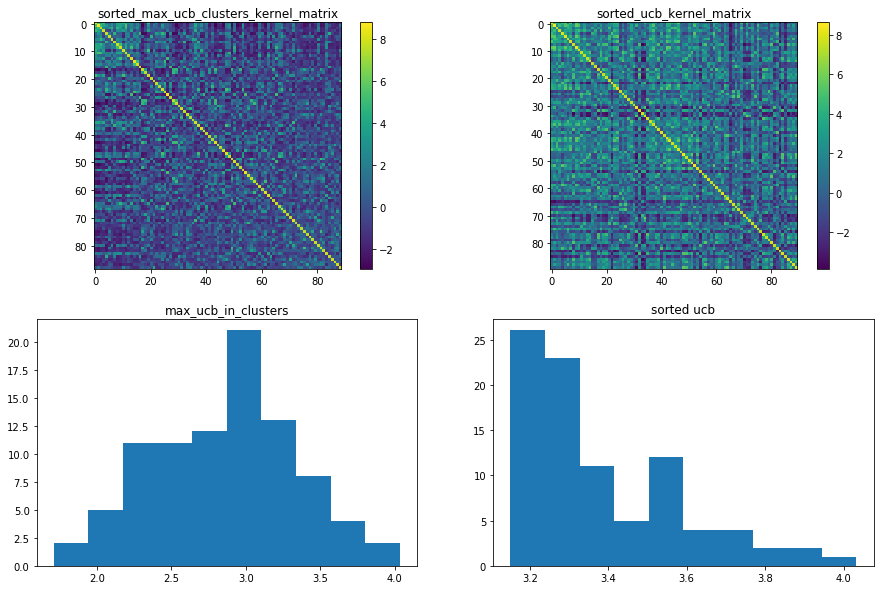

In [38]:
num_rows = 2
num_cols = 2


fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

im = a[0][0].imshow(sorted_max_ucb_clusters_kernel_matrix, cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('sorted_max_ucb_clusters_kernel_matrix')

im = a[0][1].imshow(sorted_ucb_kernel_matrix, cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('sorted_ucb_kernel_matrix')

im = a[1][0].hist(max_ucb_in_clusters['ucb'])
a[1][0].set_title('max_ucb_in_clusters')

im = a[1][1].hist(sorted_ucb[:90]['ucb'])
a[1][1].set_title('sorted ucb')